# Магазин "Стримчик". Прогноз на 2017 год.

# **Описание проекта**
Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).
Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.\
Перед нами данные до 2016 года. Сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными.\
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Данные за 2016 могут быть неполными.

# **Описание данных**
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучим данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
try:
    game = pd.read_csv('/datasets/games.csv')
except:
    game = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
    
game.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Подготовка данных

In [3]:
game.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
game.columns = game.columns.str.lower() # приведем названия столбцов к строчному виду

In [5]:
game.isna().sum() # посмотрим количество пропусков

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Удалим пропуски в столбцах `name`, `genre` (вероятнее всего ошибка в выгрузке), `year_of_release` (причина появления неизвестна, 1,6% от общего колва данных). \
Приведем столбец `year_of_release` к челочисленному значению, уберем плавающую точку.

In [6]:
game = game.dropna(subset = ['name', 'genre','year_of_release']).reset_index(drop=True)
game['year_of_release'] = game['year_of_release'].astype('int')

Пропуски в столбце `rating` заменим на ND - not defined (не определён). \
К-А старое обозначение, заменим на Е. \
AO (17+) близкое к М (18+), заменим. \
RP - Rating Pending «Рейтинг ожидается», аналогично ND, заменим.

In [7]:
game['rating'] = game['rating'].fillna('ND')
game['rating'] = game['rating'].replace(['EC','K-A'], 'E')
game['rating'] = game['rating'].replace('AO', 'M')
game['rating'] = game['rating'].replace('RP', 'ND')
game['rating'].value_counts()

ND      6677
E       3932
T       2905
M       1537
E10+    1393
Name: rating, dtype: int64

In [8]:
# изучим уникальные значения в оценках
(game[game['user_score'].
      notna()]['user_score'].
      sort_values(ascending=False).
      unique()
) 

array(['tbd', '9.7', '9.6', '9.5', '9.4', '9.3', '9.2', '9.1', '9', '8.9',
       '8.8', '8.7', '8.6', '8.5', '8.4', '8.3', '8.2', '8.1', '8', '7.9',
       '7.8', '7.7', '7.6', '7.5', '7.4', '7.3', '7.2', '7.1', '7', '6.9',
       '6.8', '6.7', '6.6', '6.5', '6.4', '6.3', '6.2', '6.1', '6', '5.9',
       '5.8', '5.7', '5.6', '5.5', '5.4', '5.3', '5.2', '5.1', '5', '4.9',
       '4.8', '4.7', '4.6', '4.5', '4.4', '4.3', '4.2', '4.1', '4', '3.9',
       '3.8', '3.7', '3.6', '3.5', '3.4', '3.3', '3.2', '3.1', '3', '2.9',
       '2.8', '2.7', '2.6', '2.5', '2.4', '2.3', '2.2', '2.1', '2', '1.9',
       '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1', '0.9',
       '0.7', '0.6', '0.5', '0.3', '0.2', '0'], dtype=object)

TBD - to be defined "предстоит определить". Заменим на их на NaN. \
Затем, сами пропуски заменим на "-1" для маркера. \
Приведем значения к типу "float", оценка имеет дробный вид.

In [9]:
game.loc[game['user_score'] == 'tbd', 'user_score'] = float('nan')
game['user_score'] = game['user_score'].fillna(-1).astype('float')

In [10]:
game['critic_score'] = game['critic_score'].fillna(-1) # аналогично "user_score"

Создадим столбец `total_sales` с суммарными продажами по всем реионам.

In [12]:
game['total_sales'] = game[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Проверим дубликаты

In [13]:
game.duplicated().sum()

0

In [14]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


### **Общий вывод:**
Мы заполнили пропуски в данных, заменили типы данных в столбцах 'year_of_release' и 'user_score'.\
Проверили дубликаты.\
Добавили столбец с суммарными продажами.

## Исследовательский анализ данных

### Посмотрим сколько игр выпускалось в разные годы и построим график.

In [15]:
game.groupby('year_of_release')['name'].count().sort_values(ascending=False).head(10)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
Name: name, dtype: int64

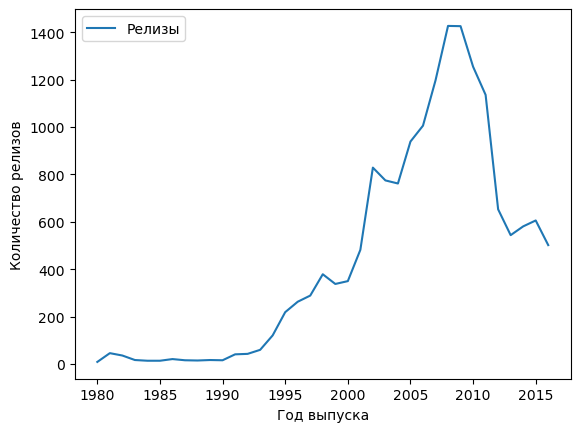

In [16]:
plt.plot(game.groupby('year_of_release')['name'].count(), label='Релизы')
plt.legend()
plt.xlabel('Год выпуска')
plt.ylabel('Количество релизов')
plt.show()

#### **Вывод:**
Из графика видно, что игры активно начали выпускать с 1992 года. Объясняется это тем, что начался технологический бум, произошел переход от растровой графики к полностью полигональному 3D. \
Видим мощный подъем с 2001 года - связан с выходом PS2. \
С 2006 года видим еще один мощный подъем - выходят Xbox360, Wii, PS3. \
С 2009 года начинается спад, думаю связано с переходом от количества к качеству.\

Можно сделать вывод, что изучать будем данные с 1992 года.

In [17]:
game = game.query('year_of_release > 1991') # сделаем срез, уберем неактуальные данные.

### Посмотрим общеее количество релизов на каждой платформе.

In [18]:
game.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.69
XB       251.57
N64      218.01
GC       196.73
GB       177.57
XOne     159.32
SNES     157.67
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       21.42
DC        15.95
NES        5.70
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Видно, что лидирующими платформами являются PS2, X360, PS3, Wii, DS, PS, PS4. \
Построим график распределения по годам.

In [21]:
platform_life = (
    game.
    pivot_table(index='platform', values='total_sales', aggfunc='sum').
    sort_values('total_sales', ascending=False)
)

PS2


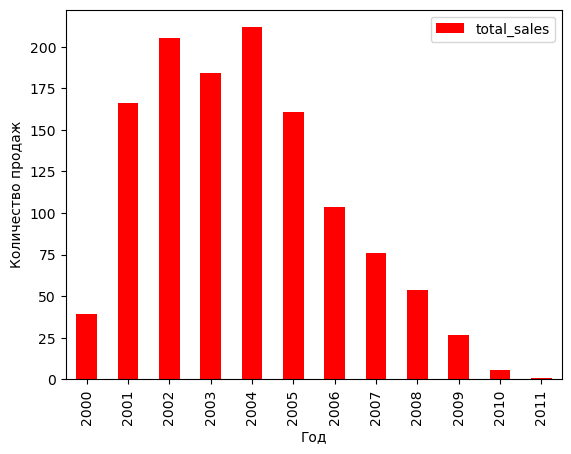

X360


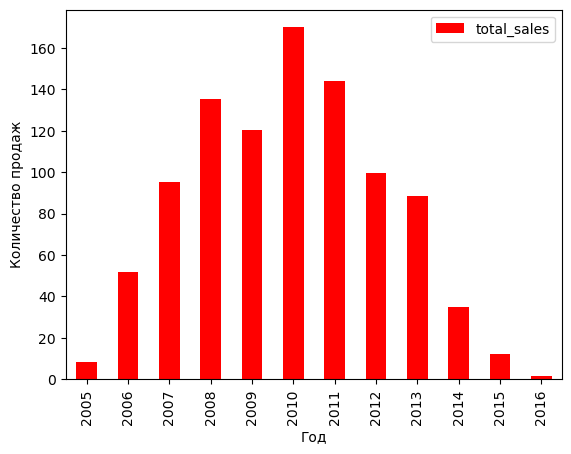

PS3


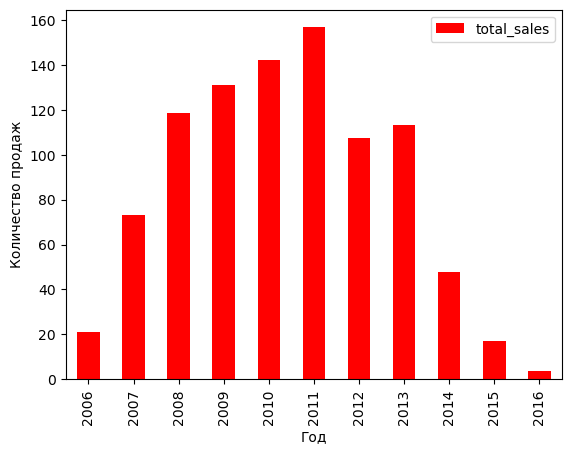

Wii


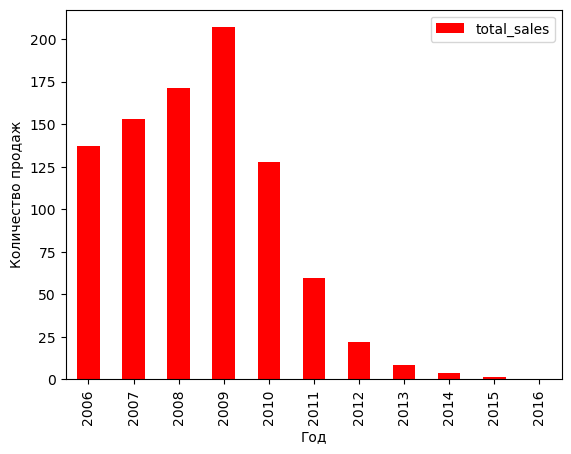

DS


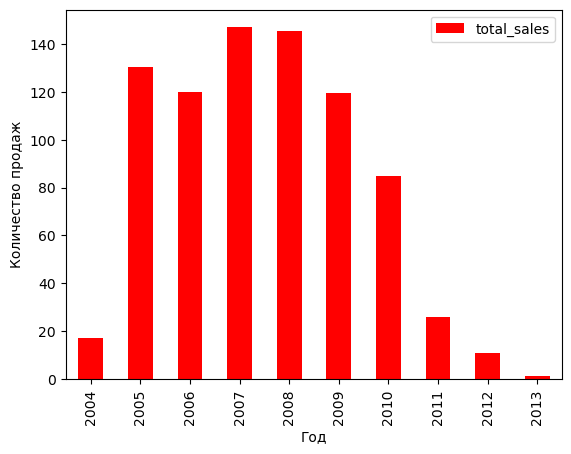

PS


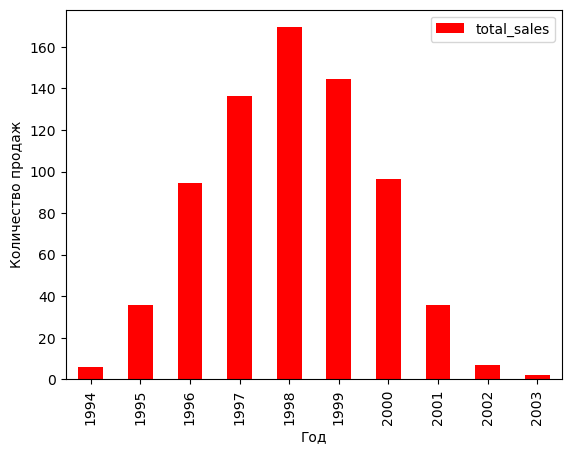

PS4


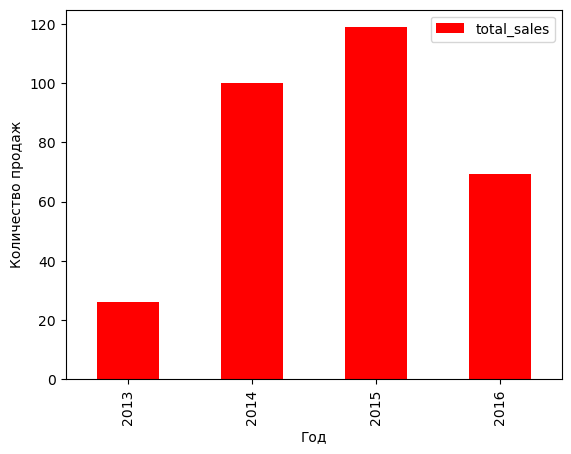

GBA


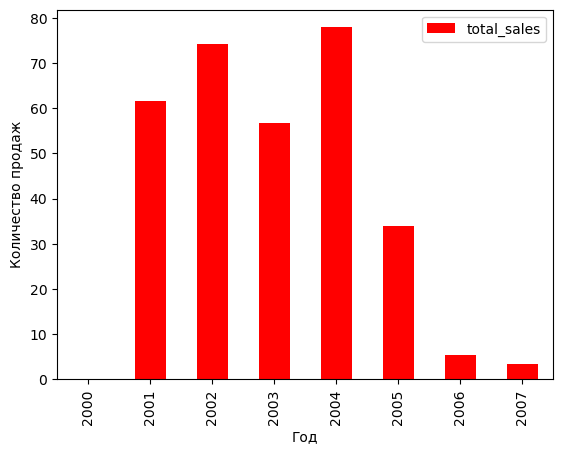

PSP


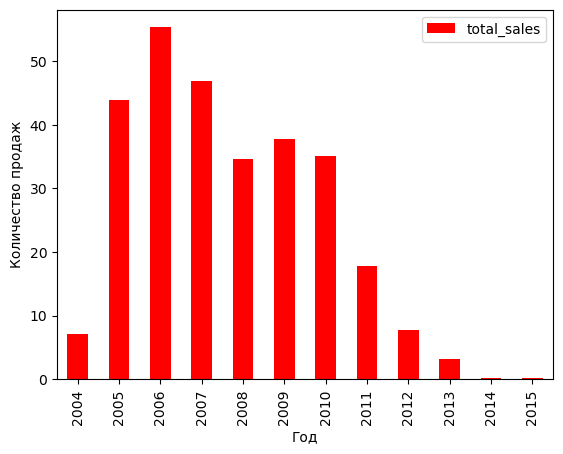

3DS


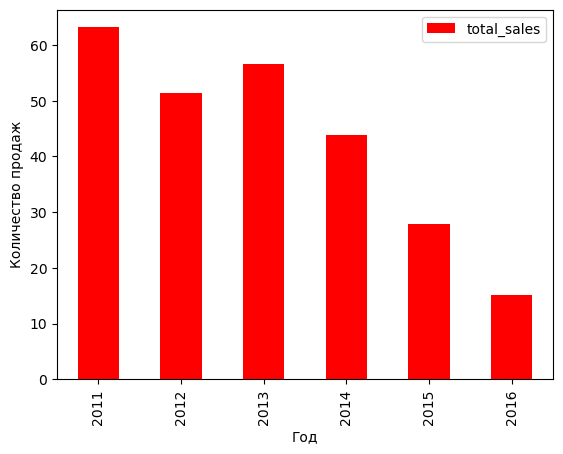

PC


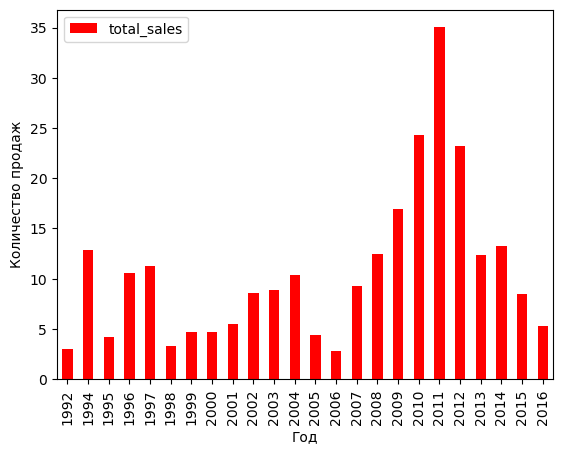

XB


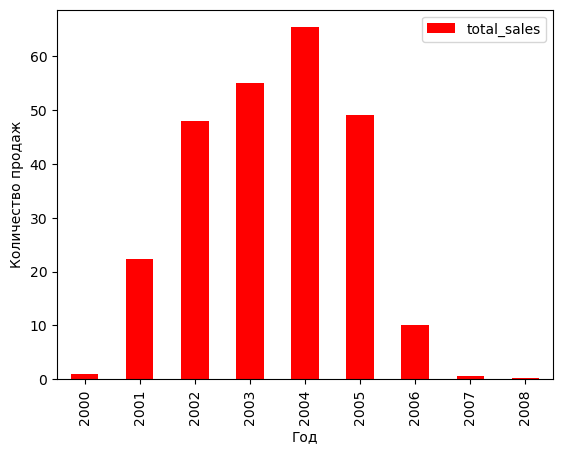

N64


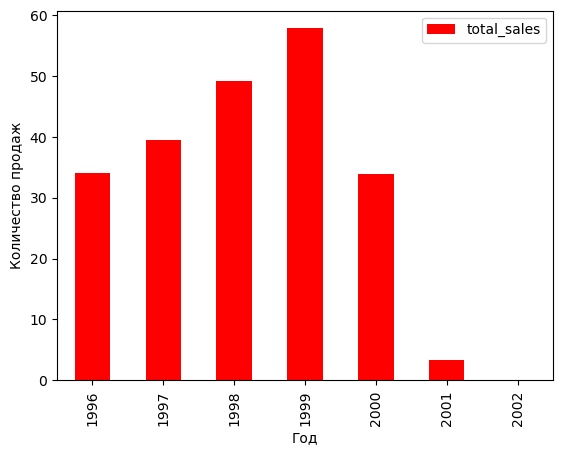

GC


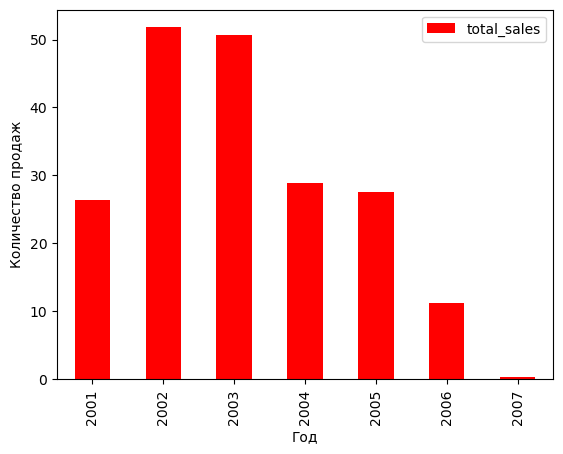

GB


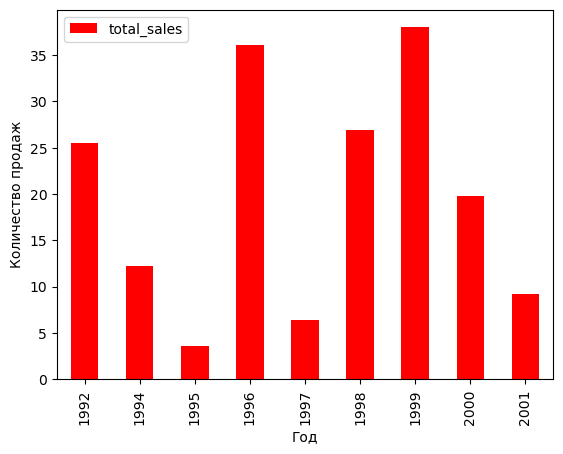

XOne


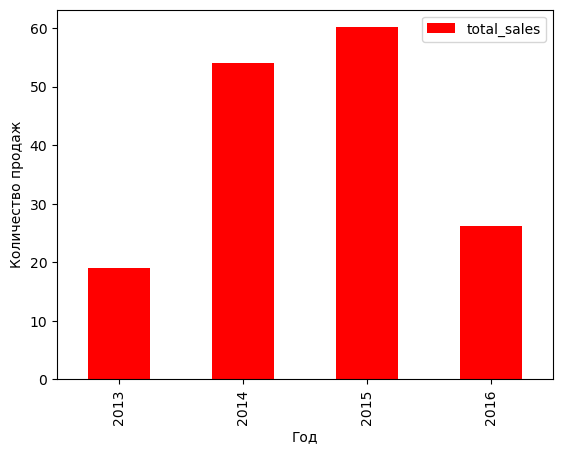

SNES


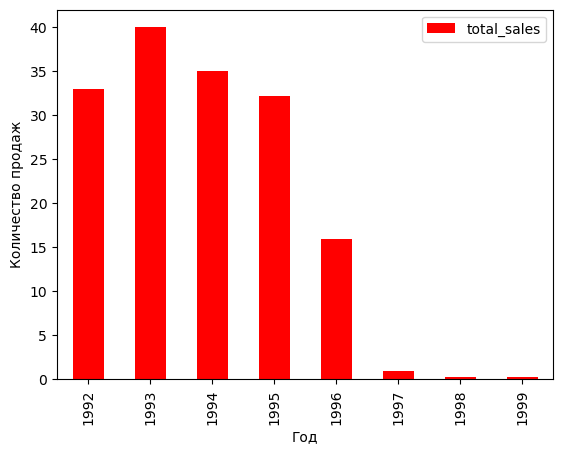

In [22]:
for platform in platform_life.index[:17]:
    print(platform)
    (game.query('platform==@platform').
    pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').
    plot(kind='bar', color='red', xlabel='Год', ylabel='Количество продаж'))
    plt.show()

#### **Вывод:**
Видим, что средняя продолжительность жизни платформы составляет 10 лет.\
Примерно каждые 6-7 лет выходит новая консоль.\
Консоль достигает своего пика примерно в середине жизни, то есть через 5 лет.\
Чтобы спрогнозировать продажи на 2017 год, будем изучать данные с 2013 года. На графиках мы видим, что с 2013 года начинается рост консолей PS4 и XOne.\

Забегая вперед, PS5 и Xbox X/S действительно вышли спустя 7 лет)

In [23]:
actual_data = game.query('year_of_release > 2012') # сделаем срез для дальнейшего анализа

### Выбор и оценка актуальных платформ

Сделаем сводную таблицу суммарных продаж по платформам и построим график.

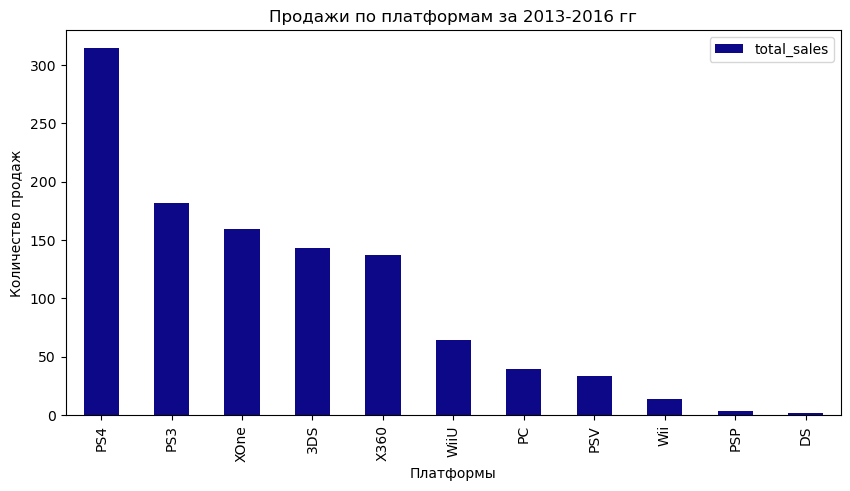

In [24]:
actual_platform_sales = actual_data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)
actual_platform_sales.plot(kind='bar', figsize=(10, 5), xlabel='Платформы', ylabel='Количество продаж', title = 'Продажи по платформам за 2013-2016 гг', colormap='plasma')
plt.show()

Рассмотрим первые 6 платформ более детально с разбивкой по годам.

PS4


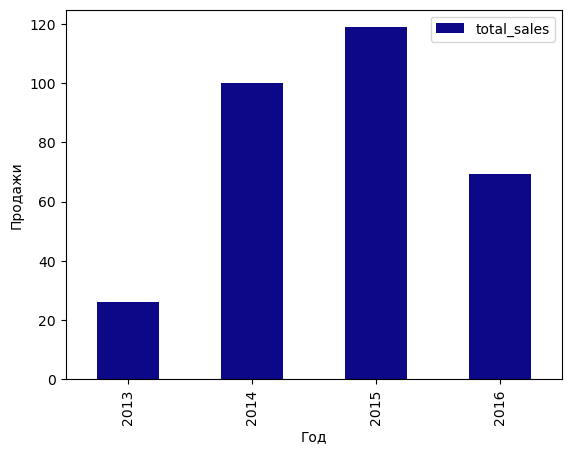

PS3


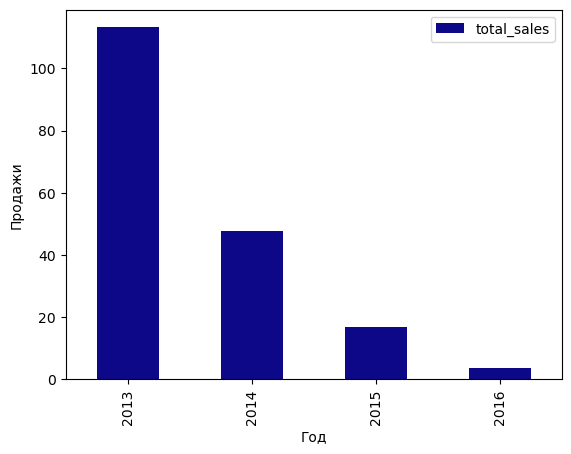

XOne


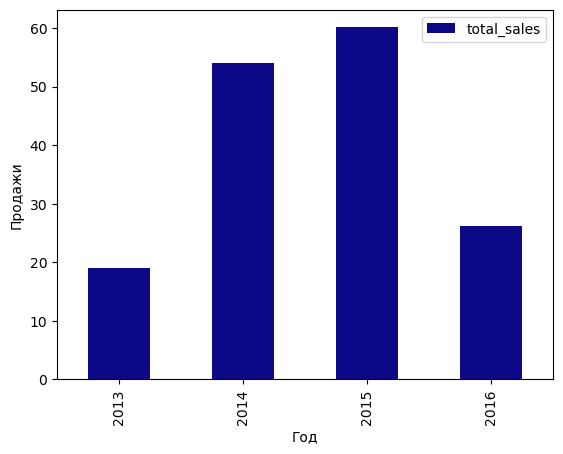

3DS


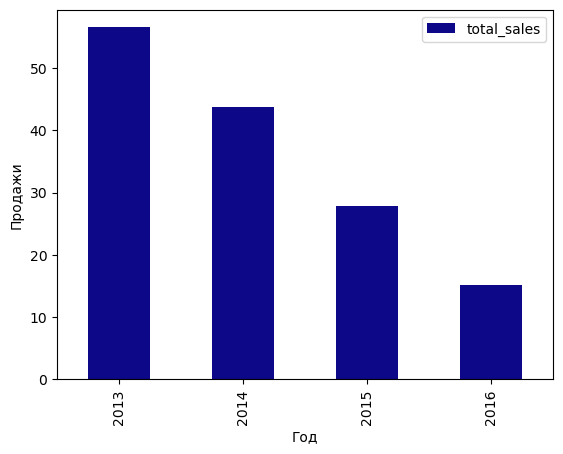

X360


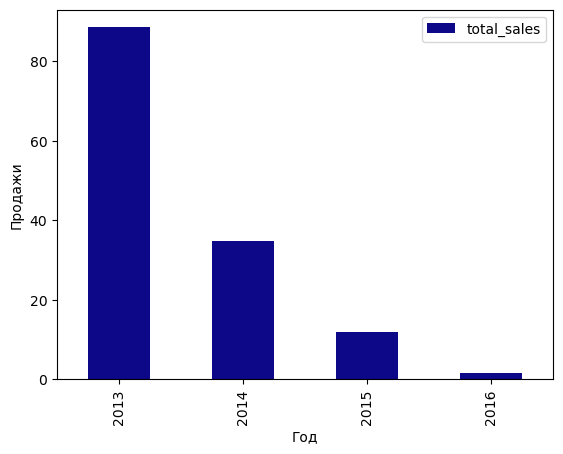

WiiU


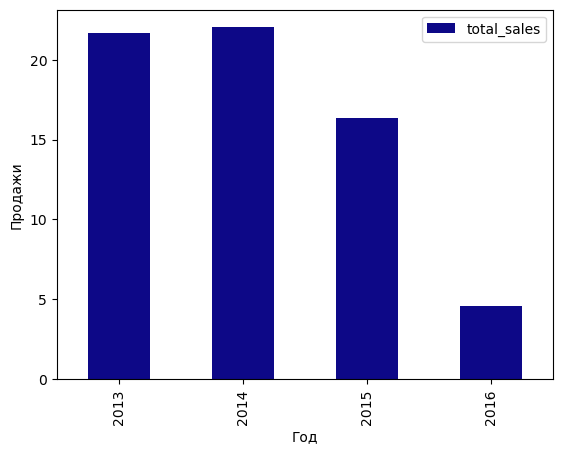

In [26]:
for platform in actual_platform_sales.index[:6]:
    print(platform)
    (actual_data.query('platform==@platform').
    pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').
    plot(kind='bar', colormap='plasma', xlabel='Год', ylabel='Продажи'))
    plt.show()

#### **Вывод:**
Из полученных данных видим, что платформы PS4, XOne, WiiU, 3DS набирают свою популярность. В 2016 году есть просадка, но это связано с недостаточным количеством данных.\
Платформы X360, PS3, Wii отжили свое, их рассматривать не будем.\
Дальнейший анализ продолжим по платформам PS4, XOne, WiiU, 3DS и PC (она продолжит существовать еще очень долго, имеет смысл включить ее в анализ).

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [27]:
actual_data_platforms = actual_data.query('platform == ["PS4", "XOne", "WiiU", "PC", "3DS"]')

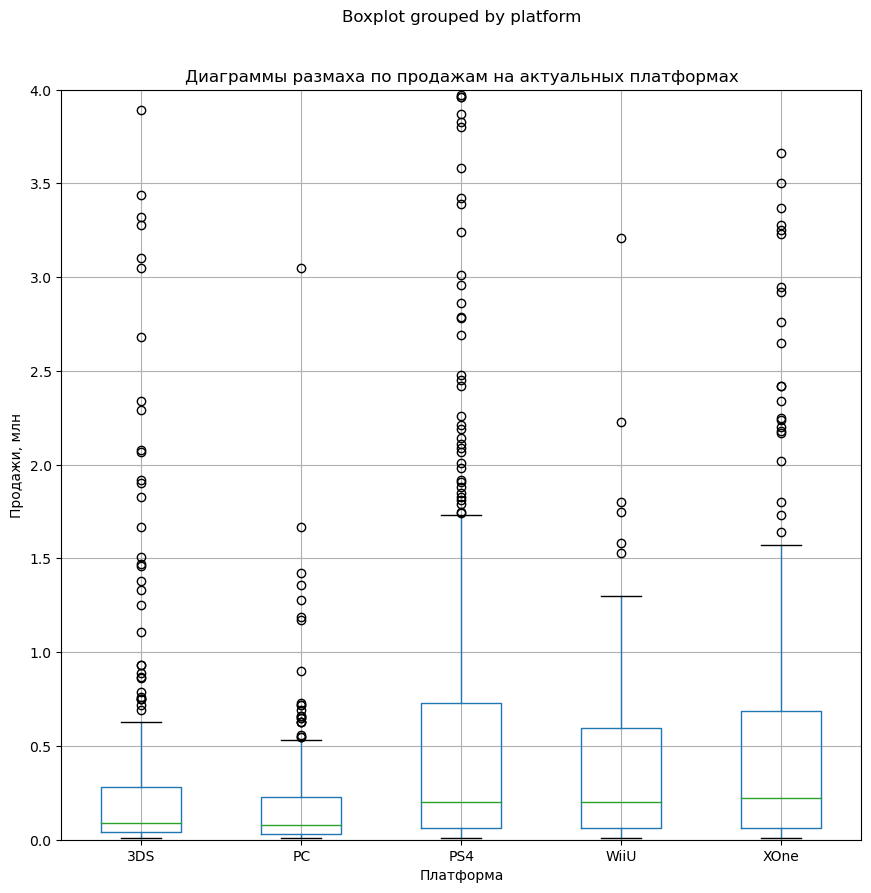

In [28]:
actual_data_platforms.boxplot(column='total_sales', by='platform', figsize=(10,10))
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
plt.ylim(0, 4)
plt.show()

#### **Вывод:**
Каждый выброс - это бестселлер.\
У платформы 3DS основные продажи составляют бестселлеры.\
PS4 и XOne имеют практически одинаковые ящики, но количество бестселлеров у PS4 сильно больше.\
Медиана по всем платформам не превышает 0.25 млн.

### Изучим как влияют на продажи отзывы пользователей и критиков внутри платформы PS4. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [29]:
ps4_sales = actual_data_platforms.query('platform == "PS4" and critic_score != -1 and user_score != -1')

Корреляция между оценкой критиков и продажами: 0.41


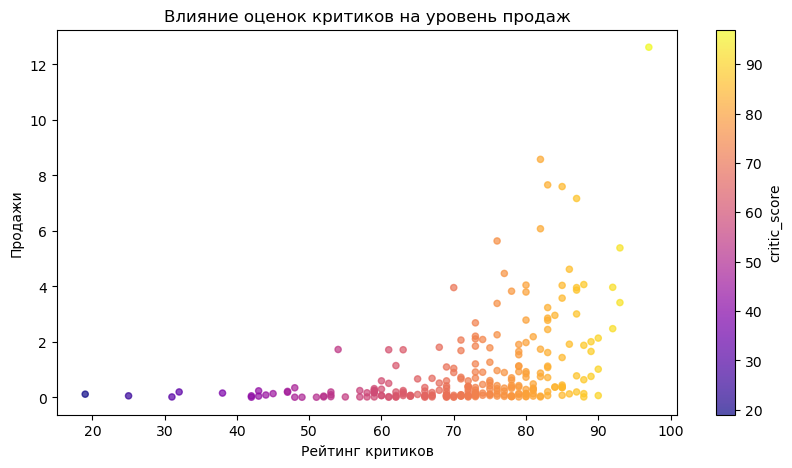

In [30]:
print(f'Корреляция между оценкой критиков и продажами: {ps4_sales.critic_score.corr(ps4_sales.total_sales):.2}')
#построим график рассеяния
ps4_sales.plot.scatter('critic_score', 'total_sales', figsize=(10, 5), alpha=0.7, c='critic_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг критиков')
plt.ylabel('Продажи')
plt.title('Влияние оценок критиков на уровень продаж')
plt.show()

Корреляция между оценкой пользователей и продажами: -0.034


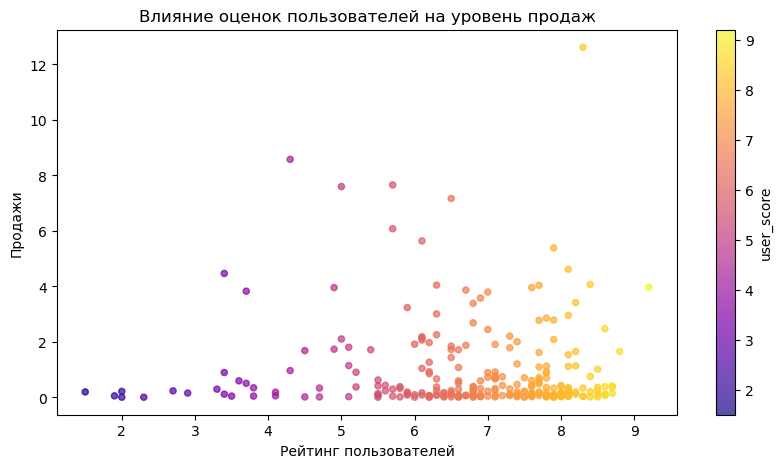

In [31]:
print(f'Корреляция между оценкой пользователей и продажами: {ps4_sales.user_score.corr(ps4_sales.total_sales):.2}')
#построим график рассеяния
ps4_sales.plot.scatter('user_score', 'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
plt.xlabel('Рейтинг пользователей')
plt.ylabel('Продажи')
plt.title('Влияние оценок пользователей на уровень продаж')
plt.show()

In [32]:
ps4_sales.query('total_sales > 7') #ради интереса посмотрим самые успешные

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


#### **Вывод:**
На платформе PS4 мы видим слабовыраженную (0.41) корреляцию между оценками критиков и продажами. График нам показывает, что большие объемы показывают игры с рейтингом 70 и выше.\
Корреляции между оценками пользователей и продажами и вовсе нет (-0.034). На продажи совсем не влияет.\
На примере Call of Duty: Advanced Warfare это прекрасно видно - оценка пользователей 5.0, а игра в топе по продажам.

### Соотнесем выводы с продажами игр на других платформах

In [33]:
for platform in ["XOne", "WiiU", "PC", "3DS"]:
    print(platform)
    ps4_sales = game.query('platform == @platform')
    print(f'Корреляция между оценкой критиков и продажами: {ps4_sales.critic_score.corr(ps4_sales.total_sales):.2}')
    print(f'Корреляция между оценкой пользователей и продажами: {ps4_sales.user_score.corr(ps4_sales.total_sales):.2}')
    print()

XOne
Корреляция между оценкой критиков и продажами: 0.27
Корреляция между оценкой пользователей и продажами: 0.12

WiiU
Корреляция между оценкой критиков и продажами: 0.3
Корреляция между оценкой пользователей и продажами: 0.26

PC
Корреляция между оценкой критиков и продажами: 0.079
Корреляция между оценкой пользователей и продажами: 0.008

3DS
Корреляция между оценкой критиков и продажами: 0.17
Корреляция между оценкой пользователей и продажами: 0.15



#### **Вывод:**
На других платформах корреляция абсолютно такая же, сответсвенно и выводы будут те же, что и на PS4.

### Посмотрим на на общее распределение игр по жанрам

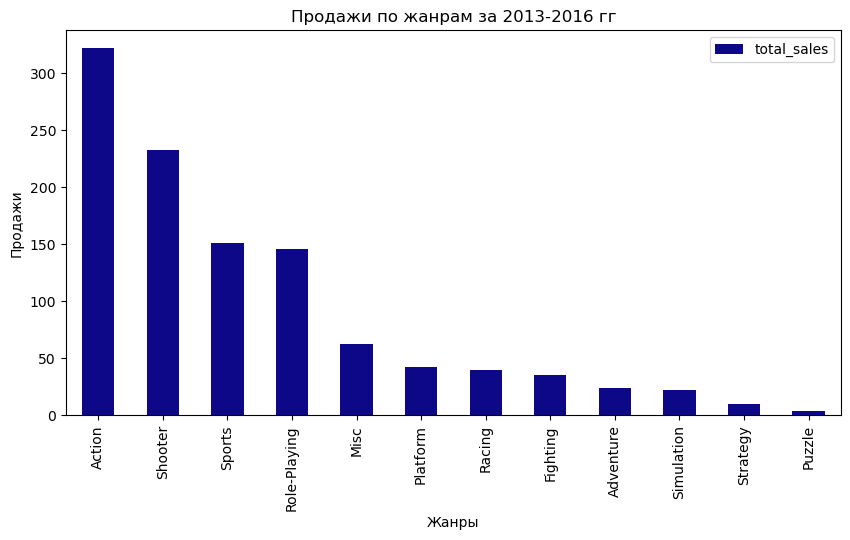

In [34]:
genre_sales = (actual_data.
               pivot_table(index='genre', values='total_sales', aggfunc='sum').
               sort_values('total_sales', ascending=False)
              )

genre_sales.plot(kind='bar', 
                 figsize=(10, 5), 
                 xlabel='Жанры', 
                 ylabel='Продажи', 
                 title = 'Продажи по жанрам за 2013-2016 гг', 
                 colormap = 'plasma'
                )
plt.show()

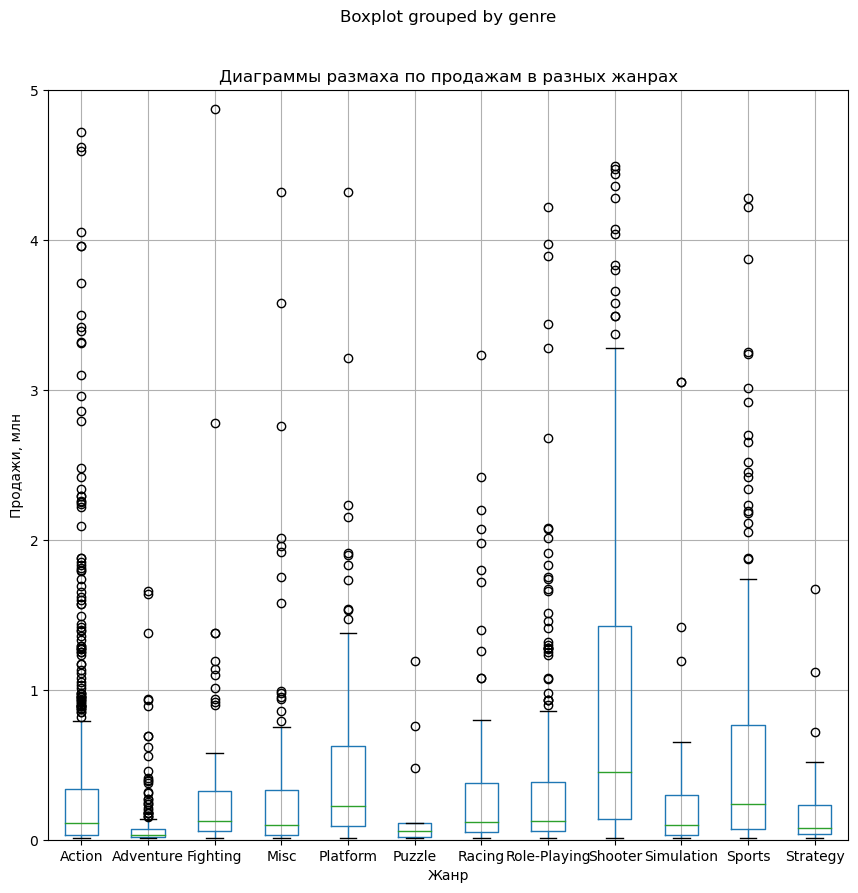

In [35]:
actual_data.boxplot(column='total_sales', by='genre', figsize=(10,10))
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн')
plt.title('Диаграммы размаха по продажам в разных жанрах')
plt.ylim(0,5)
plt.show()

#### **Вывод:**
Самыми популярными жанрами являются Экшены, шутеры, спортивные и РПГ игры.\
У Экшена одна из самых низких медиан, но большое количество бестселлеров.

In [36]:
(actual_data.
        pivot_table(
            index='genre', 
            values='total_sales', 
            aggfunc=['sum', 'mean', 'median', 'count']
                   ).
        reset_index().
        sort_values(('median', 'total_sales'), ascending=False)
)

,genre,sum,mean,median,count
,,total_sales,total_sales,total_sales,total_sales
8,Shooter,232.98,1.245882,0.450,187
10,Sports,150.65,0.703972,0.240,214
4,Platform,42.63,0.576081,0.225,74
7,Role-Playing,145.89,0.499623,0.125,292
2,Fighting,35.31,0.441375,0.125,80
6,Racing,39.89,0.469294,0.120,85
0,Action,321.87,0.420196,0.110,766
9,Simulation,21.76,0.350968,0.100,62
3,Misc,62.82,0.405290,0.100,155


Отсортировав жанры по медианным продажам, мы видим, что самыми доходными жанрами являются Shooter, Sports, Platform, RPG.\
Action не попадают даже в топ-5 доходных жанров, даже учитывая объем продаж.

### **Общий вывод:**
1. Средний цикл жизни платформы - 10 лет.
2. Самые популярные платформы - PS4, Xbox One, Nintendo 3DS, WiiU.
3. Самые популярные жанры - Action, Shooter, Sports, RPG.
4. Самые доходные жанры - Shooter, Sports, Platform, RPG.
4. К 2017 году ожидается рост продаж у популярных платформ.
5. Оценка критиков и пользоватей никак не плияет на продажи.

## Портрет пользователя

### Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)

,na_sales,percent
platform,,
PS4,108.74,24.84
XOne,93.12,21.27
X360,81.66,18.66
PS3,63.50,14.51
3DS,38.20,8.73


,eu_sales,percent
platform,,
PS4,141.09,35.97
PS3,67.81,17.29
XOne,51.59,13.15
X360,42.52,10.84
3DS,30.96,7.89


,jp_sales,percent
platform,,
3DS,67.81,48.17
PS3,23.35,16.59
PSV,18.59,13.21
PS4,15.96,11.34
WiiU,10.88,7.73


C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\2377488626.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'platform': 'Other', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\2377488626.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'platform': 'Other', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\2377488626.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'platform': 'Other', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= T

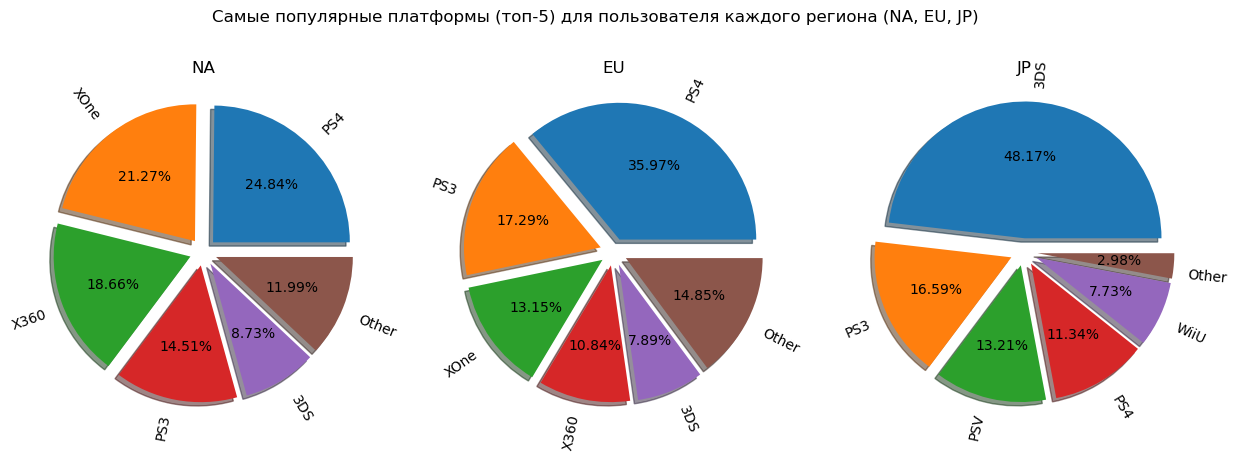

In [37]:
na_platform = actual_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_platform['percent'] = round(na_platform['na_sales']/na_platform['na_sales'].sum() *100, 2)
display(na_platform.head())

eu_platform = actual_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_platform['percent'] = round(eu_platform['eu_sales']/eu_platform['eu_sales'].sum() *100, 2)
display(eu_platform.head())

jp_platform = actual_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_platform['percent'] = round(jp_platform['jp_sales']/jp_platform['jp_sales'].sum() *100, 2)
display(jp_platform.head())

region = actual_data.columns[4:7]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)')
for i in range(3):
    game_i = (actual_data.groupby('platform')[region[i]].sum().reset_index().sort_values(region[i], ascending = False, ignore_index = True).head(5))
    game_i = game_i.append({'platform': 'Other', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
    axs[i].pie(game_i[region[i]], labels = game_i['platform'], autopct='%1.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True, rotatelabels=True)
    axs[i].set_title(game_i.columns[1].split('_')[0].upper())
plt.show()

#### **Вывод:**
Самые популярные платформы в Северной Америке: PS4, XOne, X360, PS3, 3DS\
Самые популярные платформы в Европе: PS4, PS3, XOne, X360, 3DS\
Самые популярные платформы в Японии: 3DS, PS3, PSV, PS4 и WiiU\
В Северной Америке и Европе популярные платформы похожи. Но в Японии самые популярные платформы - местные (Nintendo, Sony)

### Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)

,na_sales,percent
genre,,
Action,126.05,28.80
Shooter,109.74,25.07
Sports,65.27,14.91
Role-Playing,46.40,10.60
Misc,27.49,6.28


,eu_sales,percent
genre,,
Action,118.13,30.12
Shooter,87.86,22.40
Sports,60.52,15.43
Role-Playing,36.97,9.43
Racing,20.19,5.15


,jp_sales,percent
genre,,
Role-Playing,51.04,36.26
Action,40.49,28.76
Misc,9.20,6.54
Fighting,7.65,5.43
Shooter,6.61,4.70


C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\4183259293.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'genre': 'Other_genre', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\4183259293.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'genre': 'Other_genre', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
C:\Users\Юзер\AppData\Local\Temp\ipykernel_15300\4183259293.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_i = game_i.append({'genre': 'Other_genre', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore

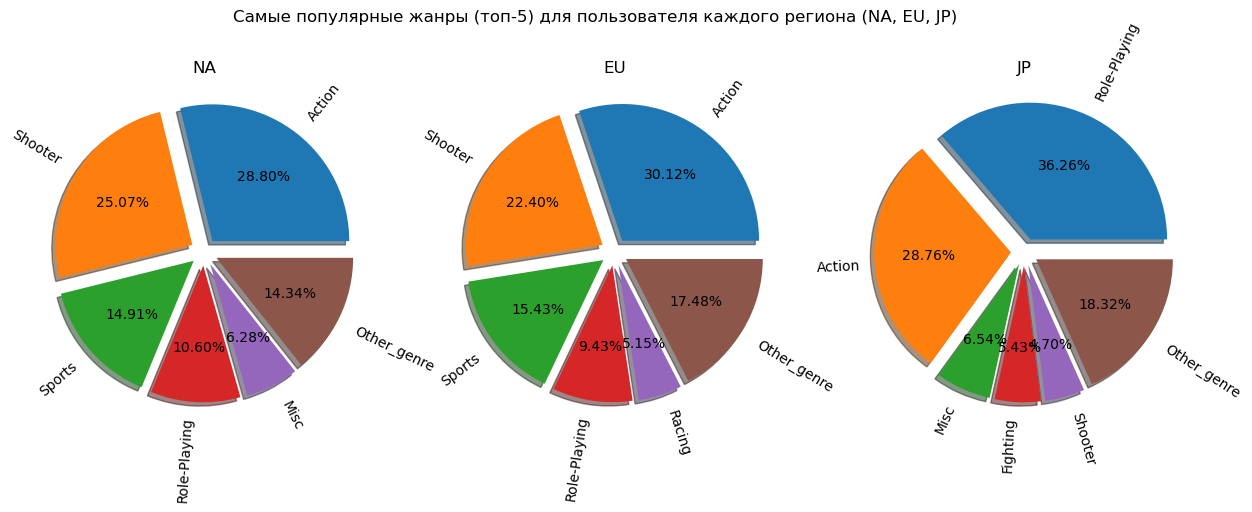

In [38]:
na_genre = actual_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_genre['percent'] = round(na_genre['na_sales']/na_genre['na_sales'].sum() *100, 2)
display(na_genre.head())

eu_genre = actual_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_genre['percent'] = round(eu_genre['eu_sales']/eu_genre['eu_sales'].sum() *100, 2)
display(eu_genre.head())

jp_genre = actual_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_genre['percent'] = round(jp_genre['jp_sales']/jp_genre['jp_sales'].sum() *100, 2)
display(jp_genre.head())

region = actual_data.columns[4:7]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)')
for i in range(3):
    game_i = (actual_data.groupby('genre')[region[i]].sum().reset_index().sort_values(region[i], ascending = False, ignore_index = True).head(5))
    game_i = game_i.append({'genre': 'Other_genre', region[i]: actual_data[region[i]].sum() - game_i[region[i]].sum()}, ignore_index= True)
    axs[i].pie(game_i[region[i]], labels = game_i['genre'], autopct='%1.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), shadow=True, rotatelabels=True)
    axs[i].set_title(game_i.columns[1].split('_')[0].upper())
plt.show()

#### **Вывод:**
Самые популярные жанры в Северной Америке: Action, Shooter, Sports, Role-Playing, Misc\
Самые популярные жанры в Европе: Action, Shooter, Sports, Role-Playing, Racing\
Самые популярные жанры в Японии: Role-Playing, Action, Misc, Fighting и Shooter\
В Северной Америке и Европе популярные жанры практически похожи.\
Но в Японии самый популярный жанр - РПГ.

### Как влияет рейтинг ESRB на продажи в отдельном регионе

,na_sales,percent
rating,,
M,165.21,37.74
ND,89.42,20.43
E,79.05,18.06
E10+,54.24,12.39
T,49.79,11.38


,eu_sales,percent
rating,,
M,145.32,37.05
E,83.36,21.25
ND,78.91,20.12
E10+,42.69,10.88
T,41.95,10.70


,jp_sales,percent
rating,,
ND,85.05,60.41
T,20.59,14.63
E,15.14,10.75
M,14.11,10.02
E10+,5.89,4.18


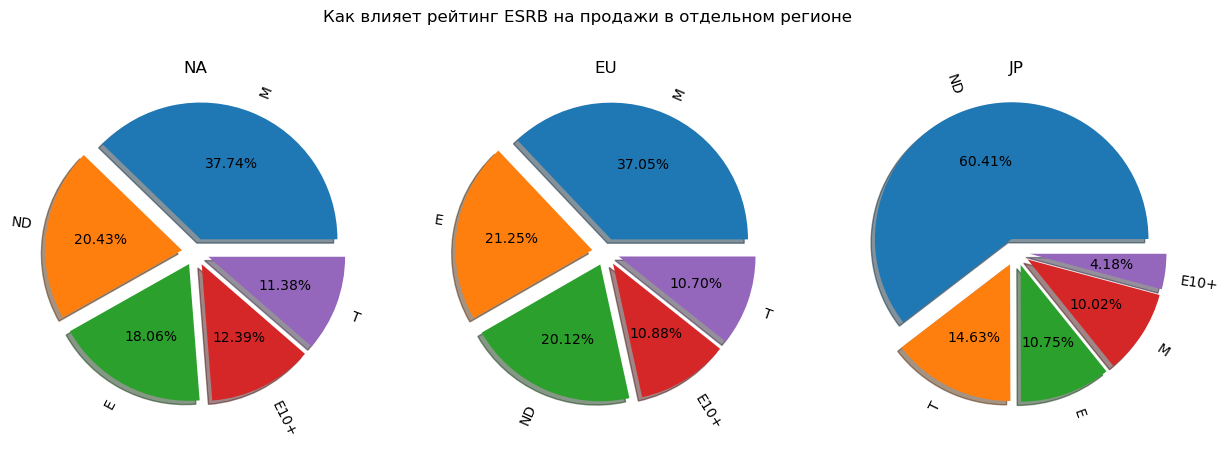

In [39]:
na_rating = actual_data.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_rating['percent'] = round(na_rating['na_sales']/na_rating['na_sales'].sum() *100, 2)
display(na_rating.head())

eu_rating = actual_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_rating['percent'] = round(eu_rating['eu_sales']/eu_rating['eu_sales'].sum() *100, 2)
display(eu_rating.head())

jp_rating = actual_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_rating['percent'] = round(jp_rating['jp_sales']/jp_rating['jp_sales'].sum() *100, 2)
display(jp_rating.head())

region = actual_data.columns[4:7]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Как влияет рейтинг ESRB на продажи в отдельном регионе')
for i in range(3):
    game_i = (actual_data.groupby('rating')[region[i]].sum().reset_index().sort_values(region[i], ascending = False, ignore_index = True).head(5))
    axs[i].pie(game_i[region[i]], labels = game_i['rating'], autopct='%1.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1), shadow=True, rotatelabels=True)
    axs[i].set_title(game_i.columns[1].split('_')[0].upper())
plt.show()

#### **Вывод:**
Рейтинг в Северной Америке и Европе совпадает.\
В Японии предпочтение отдается играм 13+. Большой процент игр без рейтинга связан с тем, что рейтинг ESRB больше относится к Северной Америке. Соответсвенно в Японии это будут пропущенные значения.

### **Общий вывод:**
Из данного анализа становится понятно, что жанры, платформы и рейтинг ESRB вляется на продажи по регионам.\
Портрет игрока по каждому региону будет следующий:\
Северная Америка и Европа - игрок 17 лет, играет на PS4 или XOne, предпочитает Экшены и шутеры.\
Япония - игрок 13 лет, играет на 3DS и PS4/PS3, предпочитает РПГ и экшены.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотезы:\
H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. \
H1: Средние пользовательские рейтинги платформ Xbox One и PC различаются. \
Значение критического уровня вероятности (альфа) примем равным 5%.

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


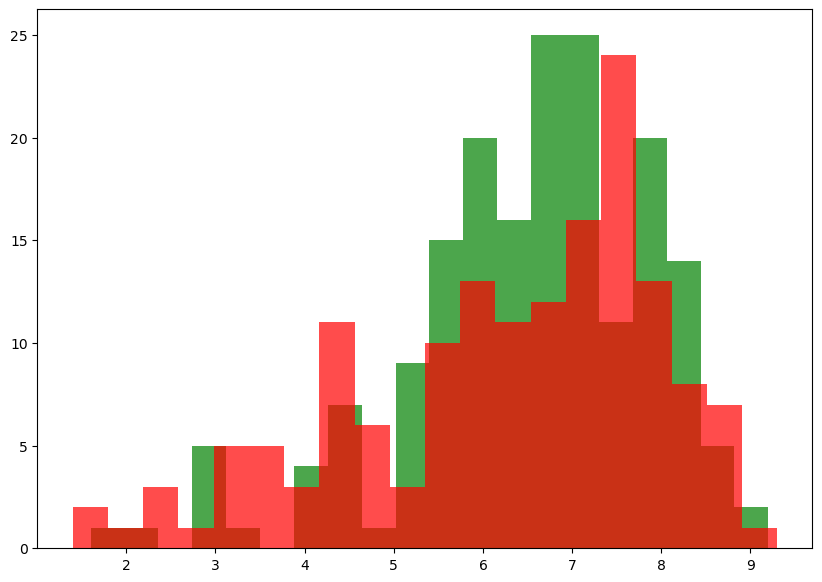

In [40]:
XOne = actual_data[(actual_data.platform == "XOne") & (actual_data.user_score != -1)]['user_score']
PC = actual_data[(actual_data.platform == "PC") & (actual_data.user_score != -1)]['user_score']
alpha = .05
results = st.ttest_ind(XOne, PC)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(XOne, bins=20, alpha=0.7, color='green')
ax.hist(PC, bins=20, alpha=0.7, color='red')
plt.show()

#### **Вывод:**
Нулевая гипотеза подтвержадет, что рейтинги в целом похожи друг на друга.

### Средние пользовательские рейтинги жанров Action и Sports разные

Гипотезы:\
H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые. \
H1: Средние пользовательские рейтинги жанров Action и Sports различаются. \
Значение критического уровня вероятности (альфа) примем равным 5%.

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


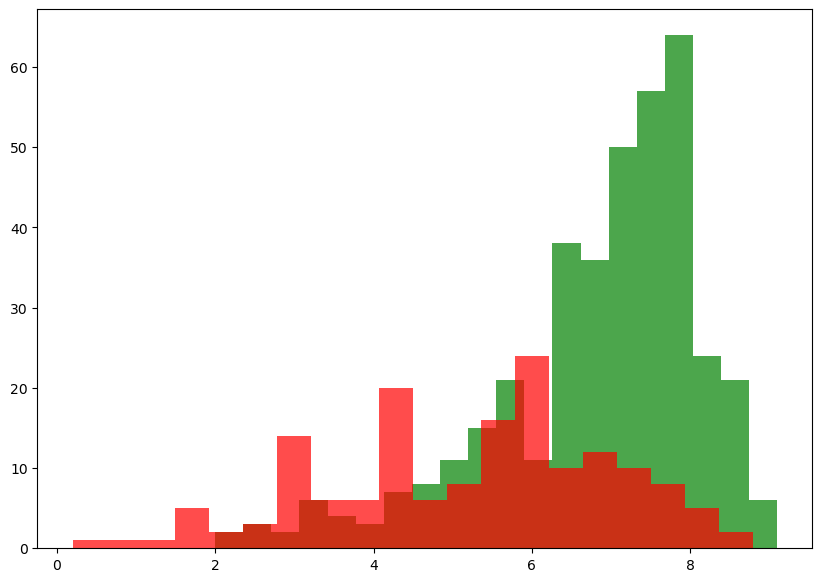

In [41]:
Action = actual_data[(actual_data.genre == "Action") & (actual_data.user_score != -1)]['user_score']
Sports = actual_data[(actual_data.genre == "Sports") & (actual_data.user_score != -1)]['user_score']
alpha = .05
results = st.ttest_ind(Action, Sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(Action, bins=20, alpha=0.7, color='green')
ax.hist(Sports, bins=20, alpha=0.7, color='red')
plt.show()

#### **Вывод:**
Альтернативная гипотеза подтвержадет, что рейтинги отличаются.

### **Общий вывод:**
Для оценки гипотез применяли тест Стюдента (можно получить два ответа "Отвергаем нулевую гипотезу" и "Не получилось отвергнуть нулевую гипотезу).\
Благодаря гипотезам стало понятно, что платформа не влияет на оценки пользователей. Но жанры влияют.

## Общий вывод

В данной работе первым этапом мы очистили наши данные от пропусков, привели названия столбцов в привычный и удобный вид. Разобрались, что такое "TBD" и отсортировали данные. Для удобства анализа, создали столбец с суммарными продажами по заданным нам регионам.

Следующим этапом был проведен анализ данных об играх, вышедших в 1980-2016 годах. На данном этапе мы выяснили, что самое большое количество релизов было на платформах PS2, XBOX360, Wii, PS3.

Анализ каждой платформы дал нам понять, что средняя продолжтельность жизни платформы составляет 10 лет, а пик ее популярности наступает спустя 5 лет с момента релиза. Как только пик проходит, спустя 1-2 года выходит новое поколение игровых платформ, то есть каждые 6-7 лет выходит новая консоль. В 2012 году происходит релиз PS4, XOne и WiiU (конец 2012) и мы уже наблюдаем хороший прирост по продажам к 2015 году (данные за 2016 год не полные, на графиках видно проседание, но зацикливаться на этом не будем). Исходя и знашего анализа становится понятно, что к 2017 мы будем подходить к пику популярности этих платформ (**PS4, XOne, Wiiu, 3DS, PC** (она +- стабильна на всем промежутке времени с переменным успехом)). В рамках прогнозирования развития нашего магазина на 2017 год, приходим к тому, что все предыдущие поколения нам уже не интересны, так как их жизненный цикл близится к завершению (10 лет).

Изучая выбранные нами актуальные платформы, мы понимаем, что опираться на отзывы в интеренете от пользователей и от авторитетных критиков не имеет смысла, так как корреляция между отзывами и продажами практически отсутсвует.

Определившись с разнообразием платформ, перейдем к жанрам.\
Из всего разнообразия жанров, самыми доходными оказались **Shooter, Sports, Platform, RPG**. Их медианные продажи оказались выше всех.\
Жанр **Action** хоть и имеет самый большой показатель по продажам и огромное количество релизов, но подобраться даже к ТОП-5 медианным продажам ему не удалось. Вероятнее всего, у этого жанра просто **большое количество бестселлеров**.

Изучив детальнее наши платформы, жанры и ретинги ESRB, мы можем описать портреты наших будущих покупателей:
- **Северная Америка и Европа - игрок 17 лет, играет на PS4 или XOne, предпочитает Экшены и шутеры.**
- **Япония - игрок 13 лет, играет на 3DS и PS4/PS3, предпочитает РПГ и экшены**.\
Японцы уважают своих местных производителей платформ, поэтому популярность 3DS и PS в этом регионе невероятно высока (Xbox даже не попал в топ-5).

Далее мы проверили две гипотезы:
1. Одинаковые ли пользовательские оценки для платформ XOne и PC.
2. Отличаются ли пользовательные оценки в зависимости от жанра. В нашем случае мы рассмотрели Action и Spots.\
Тест нам показал, что обе наши гипотезы подтверждаются. Оценка не зависит от платформы, а зависит от жанра.

На графике продаж по годам, мы увидели, что с 2009 года на рынке пошел спад, количество продаж падает. Думаю, это связано с кризисом и стоит обратить внимание.